# Эта книга призвада дать мне возможность походить в классе Network - из книги Hw_2... 

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Загрузка данных на которых будем учиться

In [5]:
data = np.loadtxt("data.csv", delimiter=",")
means = data.mean(axis=0)
# от ответов мы ничего не отнимаем
means[-1] = 0  # правильные ответы мы нормализовывать не будем: это качественные переменные
stds = data.std(axis=0)
# и делим на единицу - т.е ничего не меняем
stds[-1] = 1
data = (data - means) / stds
np.random.seed(42)
test_index = np.random.choice([True, False], len(data), replace=True, p=[0.25, 0.75])
test  = data[test_index]
train = data[np.logical_not(test_index)]
# все понятно кроме np.newaxis - чем reshape плох типо для этого и создан
train = [(d[:3][:, np.newaxis], np.eye(3, 1, k=-int(d[-1]))) for d in train]  
test =  [(d[:3][:, np.newaxis], d[-1]) for d in test]

## Функции, обеспечивающие работу данного класса

In [24]:
def sigmoid(z):
    """The sigmoid function.
    Сигмоида
    """
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function.
    Производная сигмоиды по e (шутка). По x
    """
    return sigmoid(z)*(1-sigmoid(z))

def cost_function(network, test_data, onehot=True):
    c = 0
    for example, y in test_data:
        if not onehot:
            y = np.eye(3, 1, k=-int(y))
        # feedforward - возвращаяет активации нейронной сети
        # для переданного нейрона
        yhat = network.feedforward(example)
        c += np.sum((y - yhat)**2)
    return c / len(test_data)

### Альтернативный вариант целевой функции

In [28]:
def cost_function(network, test_data, onehot=True):
    c = 0
    for example, y in test_data:
        if not onehot:
            y = np.eye(3, 1, k=-int(y))
        # feedforward - возвращаяет активации нейронной сети
        # для переданного нейрона
        yhat = network.feedforward(example)
        c += np.sum((y - yhat)**2)
    #return c / len(test_data)
    return (c/len(test_data) +
            network.l1*(sum([np.abs(w).sum() for w in network.weights])) + 
            (network.l2/2)*(sum([(w**2).sum() for w in network.weights]))) # вот оно докинул регуляризацию

## Собсвенно сам класс - в кишочках которого я собираюсь лазать

In [3]:
class Network:

    def __init__(self, sizes, output=True):
        """
        Список ``sizes`` содержит количество нейронов в соответствующих слоях
        нейронной сети. К примеру, если бы этот лист выглядел как [2, 3, 1],
        то мы бы получили трёхслойную нейросеть, с двумя нейронами в первом
        (входном), тремя нейронами во втором (промежуточном) и одним нейроном
        в третьем (выходном, внешнем) слое. Смещения и веса для нейронных сетей
        инициализируются случайными значениями, подчиняющимися стандартному нормальному
        распределению. Обратите внимание, что первый слой подразумевается слоем, 
        принимающим входные данные, поэтому мы не будем добавлять к нему смещение 
        (делать это не принято, поскольку смещения используются только при 
        вычислении выходных значений нейронов последующих слоёв)
        """
        
        # получили число слоёв
        self.num_layers = len(sizes)
        # сохранили параметры слоёв
        self.sizes = sizes
        # генерируем начальный массив смещений
        # пртом что смещения добавляются только со второго слоя
        # (первого внутреннего) обрати внимание на sizes[1:]
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        # получаем начальные веса - очень интересный однострочник,
        # позволяющий перебрать i-й и (i+1)-й слои
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.output = output

    def feedforward(self, a):
        """
        Вычислить и вернуть выходную активацию нейронной сети
        при получении ``a`` на входе (бывшее forward_pass).
        """
        # тут собсвенно для каждого слоя нейроннной сети
        # формируется выходная активация - прямое распространение 
        # активации
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """
        Обучить нейронную сеть, используя алгоритм стохастического
        (mini-batch) градиентного спуска. 
        ``training_data`` - лист кортежей вида ``(x, y)``, где 
        x - вход обучающего примера, y - желаемый выход (в формате one-hot). 
        Роль остальных обязательных параметров должна быть понятна из их названия.
        Если предоставлен опциональный аргумент ``test_data``, 
        то после каждой эпохи обучения сеть будет протестирована на этих данных 
        и промежуточный результат обучения будет выведен в консоль. 
        ``test_data`` -- это список кортежей из входных данных 
        и номеров правильных классов примеров (т.е. argmax(y),
        если y -- набор ответов в той же форме, что и в тренировочных данных).
        Тестирование полезно для мониторинга процесса обучения,
        но может существенно замедлить работу программы.
        """
        
        if test_data is not None: n_test = len(test_data)
        # это я дописал для того чтобы shuffle из 70 строки не перемешивал исходные данные
        training_data = training_data.copy()
        # получение числа примеров, которые будут использоваться для обучения
        n = len(training_data)
        success_tests = 0
        for j in range(epochs):
            # функция random.shuffle - перемешивает переданный лист в
            # случайном порядке (random - стандартная библиотека)
            random.shuffle(training_data)
            
            # формуруются кусочки - срезы тренировочных данных
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                # для каждого батча производиться обновление
                # весов и  смещений нейрнной сети
                self.update_mini_batch(mini_batch, eta)
            if test_data is not None and self.output:
                success_tests = self.evaluate(test_data)
                print("Эпоха {0}: {1} / {2}".format(
                    j, success_tests, n_test))
            elif self.output:
                print("Эпоха {0} завершена".format(j))
        if test_data is not None:
            return success_tests / n_test

    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        # начальная инициализация градиента
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # достаем по примеру из минибатча
        for x, y in mini_batch:
            # задейсвуем алгоритм обратного распределения ошибки
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

    def backprop(self, x, y):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` -- градиент целевой функции по всем параметрам сети.
        ``nabla_b`` и ``nabla_w`` -- послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """
        # Эту функцию необходимо реализовать
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # сдесь буду держать активации промежуточных слоев
        a_arr = [x]
        # прямое распространение (forward pass)
        for b, w in zip(self.biases, self.weights):
            # посчитать активации
            a = sigmoid(np.dot(w, a_arr[-1])+b)
            a_arr.append(a)

        # обратное распространение (backward pass)
        delta =  (a_arr[-1] - y)*a_arr[-1]*(1 - a_arr[-1])# ошибка выходного слоя
        nabla_b[-1] = delta # производная J по смещениям выходного слоя
        nabla_w[-1] = np.dot(delta, a_arr[-2].T) # производная J по весам выходного слоя



        # Обратите внимание, что переменная l в цикле ниже используется
        # немного иначе, чем в лекциях.  Здесь l = 1 означает последний слой, 
        # l = 2 - предпоследний и так далее.  
        # Мы перенумеровали схему, чтобы с удобством для себя 
        # использовать тот факт, что в Python к переменной типа list 
        # можно обращаться по негативному индексу.
        for l in range(2, self.num_layers):
            # дополнительные вычисления, чтобы легче записывалось
            #
            delta = np.dot(self.weights[-l+1].T, delta)*a_arr[-l]*(1-a_arr[-l]) # ошибка на слое L-l
            nabla_b[-l] = delta # производная J по смещениям L-l-го слоя
            nabla_w[-l] = np.dot(delta, a_arr[-l-1].T) # производная J по весам L-l-го слоя
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """
        Вернуть количество тестовых примеров, для которых нейронная сеть
        возвращает правильный ответ. Обратите внимание: подразумевается,
        что выход нейронной сети - это индекс, указывающий, какой из нейронов
        последнего слоя имеет наибольшую активацию.
        """
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """
        Возвращает вектор частных производных (\partial C_x) / (\partial a) 
        целевой функции по активациям выходного слоя.
        """
        return (output_activations-y)

### Наследник включиющий регуляризацию

In [16]:
# приколько, подрубили наследование
class RegularizedNetwork(Network):
    def __init__(self, sizes, output=True, l1=0, l2=0):
        super().__init__(sizes, output)
        self.l1 = l1
        self.l2 = l2
        
    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch. Учесть штрафы за L1 и L2.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        eps = eta / len(mini_batch)
        # вот тут учитытвается отличие произоводной с регуляризацией
        #self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        #self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]
        self.weights = [w - eps * nw - self.l1 * np.sign(w) - self.l2 * w for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

### Функция, что обучает нейронную сеть для заданных параментов регуляризации

In [14]:
learning_rate = 1
batch_size = 5
layers = [3,6,3]

def teach_net(l1):
    l2 = l1
    np.random.seed(47)
    random.seed(36)
    nn = RegularizedNetwork(layers, output=False, l1=float(l1), l2=float(l2))
    CER = []
    cost_train = []
    cost_test  = []

    for _ in range(150):
        nn.SGD(training_data=train, epochs=1, mini_batch_size=batch_size, eta=learning_rate)
        CER.append(1 - nn.evaluate(test) / len(test))
        cost_test.append(cost_function(nn, test, onehot=False))
        cost_train.append(cost_function(nn, train, onehot=True))

        
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,2,1)
    plt.ylim(0, 1)
    plt.plot(CER)
    plt.title("Classification error rate")
    plt.ylabel("Percent of incorreclty identified observations")
    plt.xlabel("Epoch number")

    fig.add_subplot(1,2,2)
    plt.plot(cost_train, label="Training error", color="orange")
    plt.plot(cost_test, label="Test error", color="blue")
    plt.title("Learning curve")
    plt.ylabel("Cost function")
    plt.xlabel("Epoch number")
    plt.legend()
    fig.suptitle('$\lambda_1 = \lambda_2 = '+ str(l1) + '$')

### Начнем эксперименты

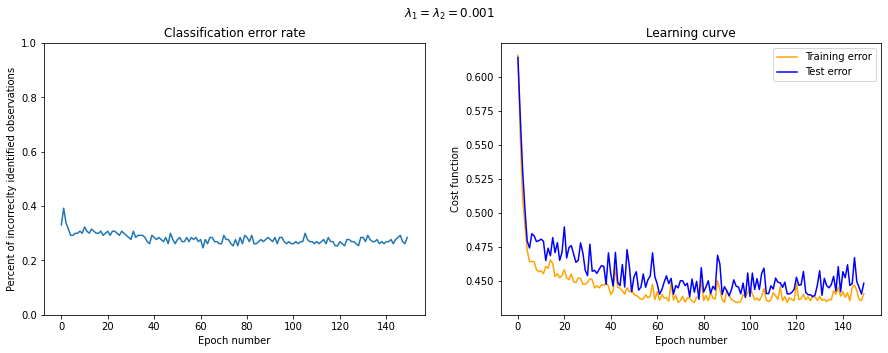

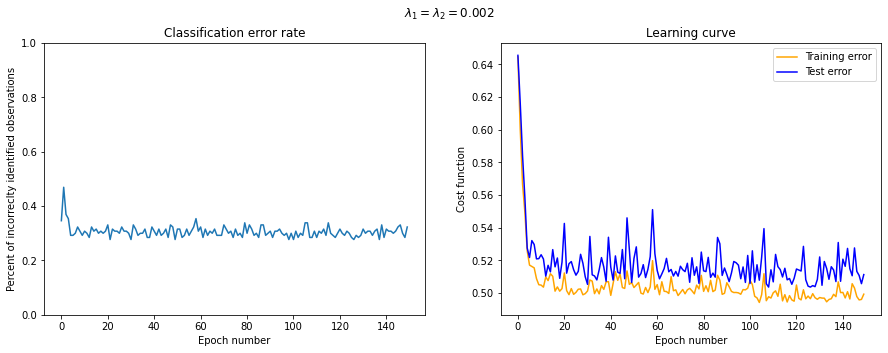

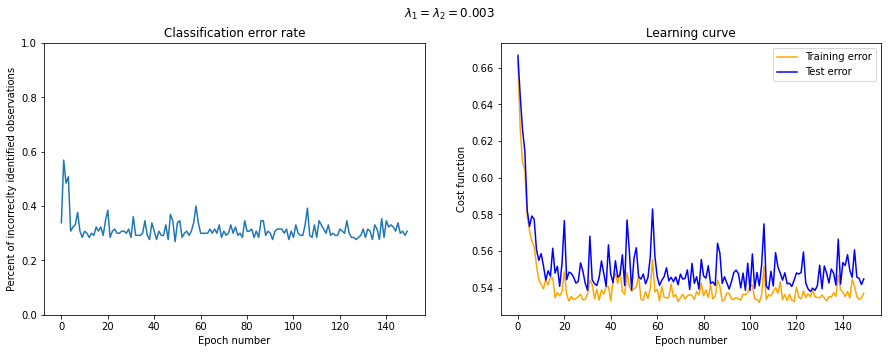

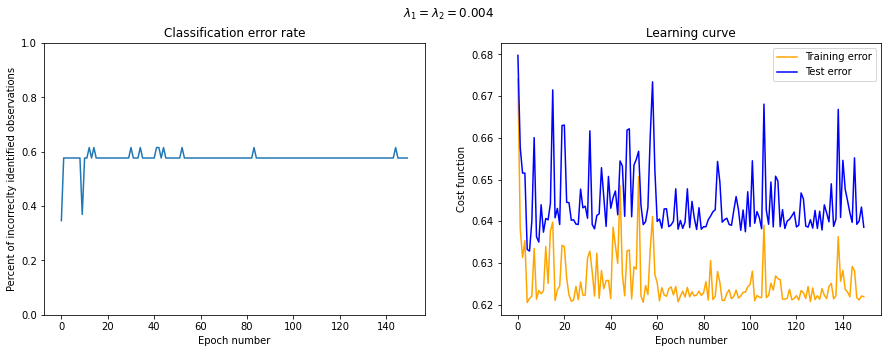

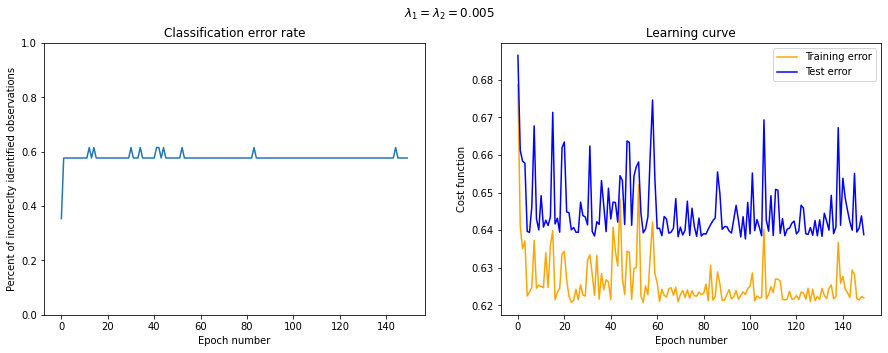

In [29]:
for l1 in np.linspace(0.001, 0.005, 5):
    teach_net(l1)
    plt.savefig("l = " + str(l1) + '.png')